# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.4.1


# Загружаем разметку

In [38]:
import os
import json
from glob import glob

TRAIN_PREFIX = '/content/drive/MyDrive/data/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('/content/drive/MyDrive/data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [ ]:
boxes = load_annotations()  # загружаем разметку детекций

In [ ]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,bet,200
1,yft,734
2,dol,117
3,lag,67
4,shark,176


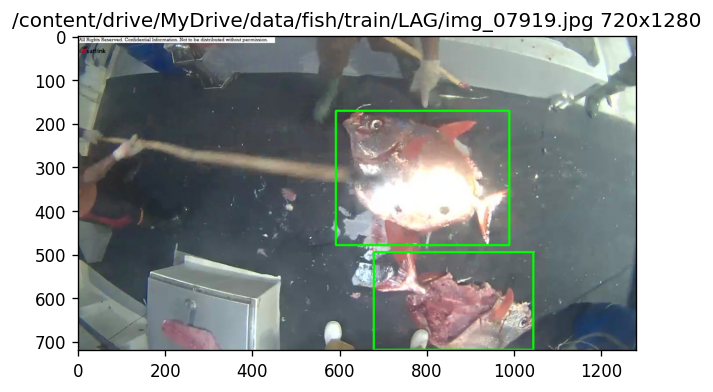

In [ ]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

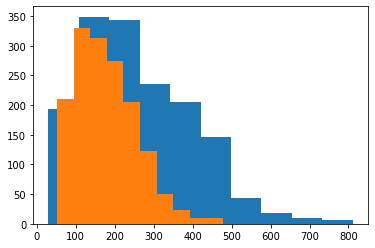

In [ ]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [ ]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

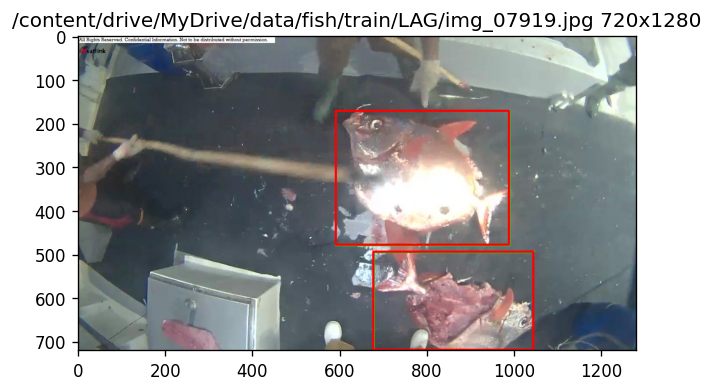

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [ ]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [ ]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0   

## Обучение

In [ ]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])

In [ ]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=35,
          callbacks=[checkpoint])

Epoch 1/35
 10/258 [>.............................] - ETA: 1:17 - loss: 4.9850 - confidence_loss: 0.9118
Epoch 00001: loss improved from inf to 4.27632, saving model to fishdetector.hdf5
 20/258 [=>............................] - ETA: 1:17 - loss: 4.3322 - confidence_loss: 0.8876
Epoch 00001: loss improved from 4.27632 to 3.27461, saving model to fishdetector.hdf5
 30/258 [==>...........................] - ETA: 1:15 - loss: 3.8638 - confidence_loss: 0.8599
Epoch 00001: loss improved from 3.27461 to 2.68837, saving model to fishdetector.hdf5
 40/258 [===>..........................] - ETA: 1:12 - loss: 3.5225 - confidence_loss: 0.8345
Epoch 00001: loss improved from 2.68837 to 2.35692, saving model to fishdetector.hdf5
 50/258 [====>.........................] - ETA: 1:09 - loss: 3.2600 - confidence_loss: 0.8122
Epoch 00001: loss improved from 2.35692 to 2.10137, saving model to fishdetector.hdf5
 60/258 [=====>........................] - ETA: 1:05 - loss: 3.0475 - confidence_loss: 0.7925

## Результат работы детектора

In [ ]:
# model.load_weights('/content/drive/MyDrive/data/fish/fishdetector_weights.hdf5')

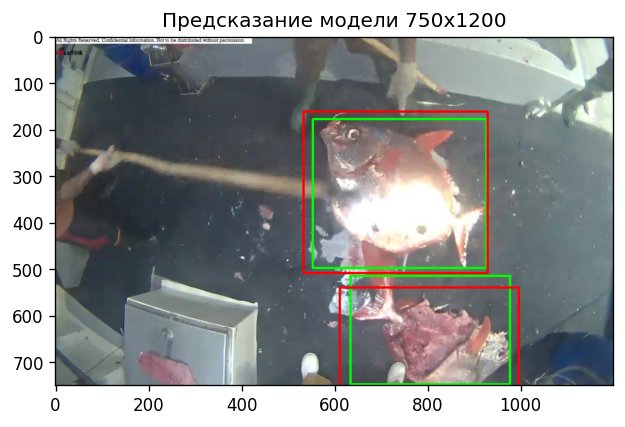

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

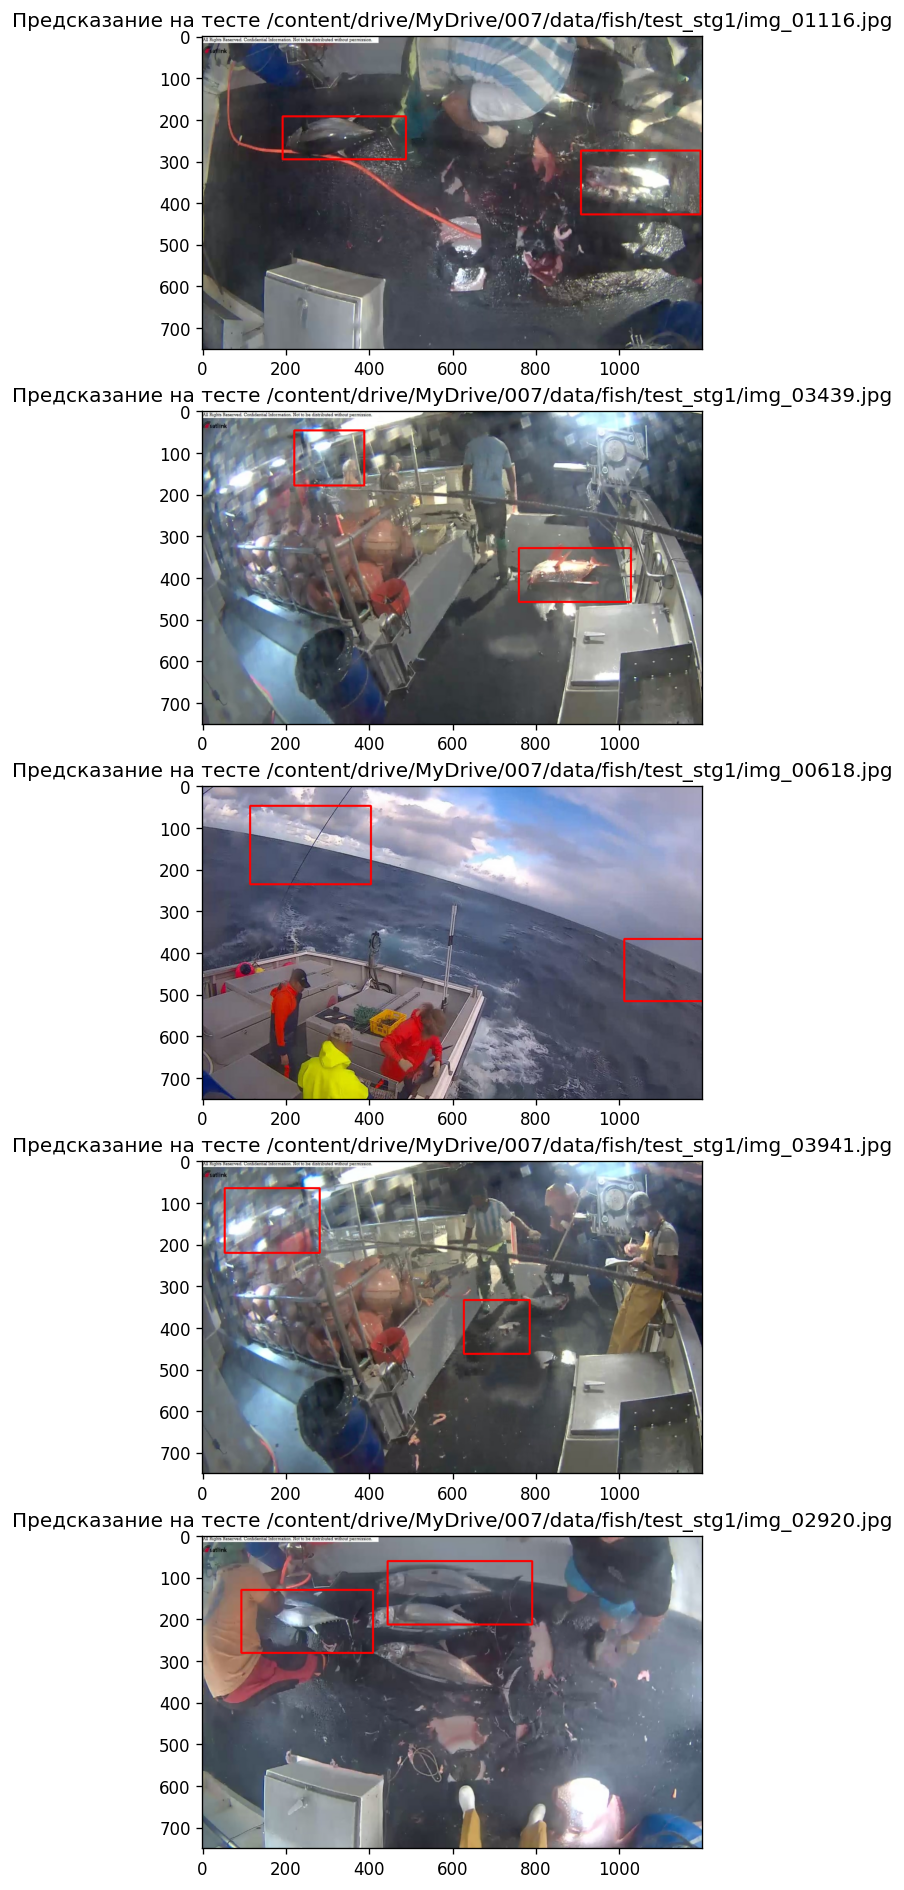

In [40]:
test_images = glob('/content/drive/MyDrive/data/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));